# Shota Imanaga: MLB 1st-2nd Year Pitching Analysis (2024-2025)

**カブス今永昇太の投球スタイル変化を追う**

- 2024（ルーキー）vs 2025前半 vs 2025後半 の3期間比較
- 球種配分の変化
- 球速・スピンレートの推移
- イニング別球速低下（スタミナパターン）
- 空振り率（Whiff Rate）の変化
- 2ストライク時の決め球戦略

---

In [15]:
!pip install pybaseball duckdb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.3 MB/s eta 0:00:00


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_pitcher
import duckdb

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# ====== Settings ======
PITCHER_ID = 684007  # Shota Imanaga MLBAM ID
YEARS = [2024, 2025]
GAME_TYPE = 'R'  # Regular season only
ASB_DATE = '2025-07-15'  # All-Star Break cutoff for 1H/2H split
# ======================

## 1. Data Acquisition

In [17]:
dfs = []
for year in YEARS:
    print(f'Fetching {year}...')
    df_year = statcast_pitcher(f'{year}-03-01', f'{year}-12-31', PITCHER_ID)
    df_year['season'] = year
    dfs.append(df_year)
    print(f'  {year}: {len(df_year):,} pitches')

df_raw = pd.concat(dfs, ignore_index=True)
print(f'\nTotal (raw): {len(df_raw):,} pitches')

# Filter regular season only
con = duckdb.connect()
df = con.execute(f"""
    SELECT *,
        CASE
            WHEN season = 2024 THEN '2024'
            WHEN season = 2025 AND game_date < '{ASB_DATE}' THEN '2025-1H'
            ELSE '2025-2H'
        END as period
    FROM df_raw
    WHERE game_type = '{GAME_TYPE}'
""").df()

print(f'Total (regular season): {len(df):,} pitches')
print(f'\nPeriod breakdown:')
for period in ['2024', '2025-1H', '2025-2H']:
    n = len(df[df['period'] == period])
    print(f'  {period}: {n:,} pitches')

Fetching 2024...
Gathering Player Data
  2024: 2,816 pitches
Fetching 2025...
Gathering Player Data
  2025: 2,416 pitches

Total (raw): 5,232 pitches
Total (regular season): 4,772 pitches

Period breakdown:
  2024: 2,594 pitches
  2025-1H: 1,026 pitches
  2025-2H: 1,152 pitches


## 2. Data Summary

In [18]:
PERIODS = ['2024', '2025-1H', '2025-2H']

summary = con.execute("""
    SELECT
        period,
        COUNT(*) as pitches,
        COUNT(DISTINCT game_date) as games,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(MAX(release_speed), 1) as max_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        COUNT(DISTINCT pitch_type) as pitch_types
    FROM df
    GROUP BY period
    ORDER BY period
""").df()

print('=== Period Overview ===')
print(summary.to_string(index=False))
print(f'\nTotal: {len(df):,} pitches')

=== Period Overview ===
 period  pitches  games  avg_velo  max_velo  avg_spin  pitch_types
   2024     2594     29      87.1      94.6    1997.0            8
2025-1H     1026     12      86.2      93.8    2049.0            6
2025-2H     1152     13      86.3      93.0    2153.0            6

Total: 4,772 pitches


## 3. Pitch Arsenal Overview

In [19]:
arsenal = con.execute("""
    SELECT
        period,
        pitch_type,
        COUNT(*) as count,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period), 1) as pct,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY period, count DESC
""").df()

print('=== Pitch Arsenal by Period ===')
for period in PERIODS:
    data = arsenal[arsenal['period'] == period]
    print(f'\n--- {period} ---')
    print(data[['pitch_type', 'count', 'pct', 'avg_velo', 'avg_spin']].to_string(index=False))

=== Pitch Arsenal by Period ===

--- 2024 ---
pitch_type  count  pct  avg_velo  avg_spin
        FF   1343 51.9      91.7    2442.0
        FS    797 30.8      82.9    1119.0
        ST    196  7.6      81.6    2512.0
        CH     99  3.8      81.6    1678.0
        CU     84  3.2      72.7    2423.0
        SI     58  2.2      89.0    1867.0
        FC     12  0.5      89.8    2387.0
        CS      1  0.0      53.9    1645.0

--- 2025-1H ---
pitch_type  count  pct  avg_velo  avg_spin
        FF    507 49.5      90.9    2489.0
        FS    365 35.6      82.7    1241.0
        ST    114 11.1      80.2    2545.0
        CU     28  2.7      71.7    2494.0
        SL      6  0.6      80.9    2605.0
        SI      4  0.4      88.2    1892.0

--- 2025-2H ---
pitch_type  count  pct  avg_velo  avg_spin
        FF    552 47.9      90.8    2476.0
        FS    318 27.6      83.2    1318.0
        ST    248 21.5      80.4    2528.0
        SI     24  2.1      88.2    1762.0
        CU      7

## 4. Pitch Mix Evolution

3期間で球種の使い分けがどう変わったか

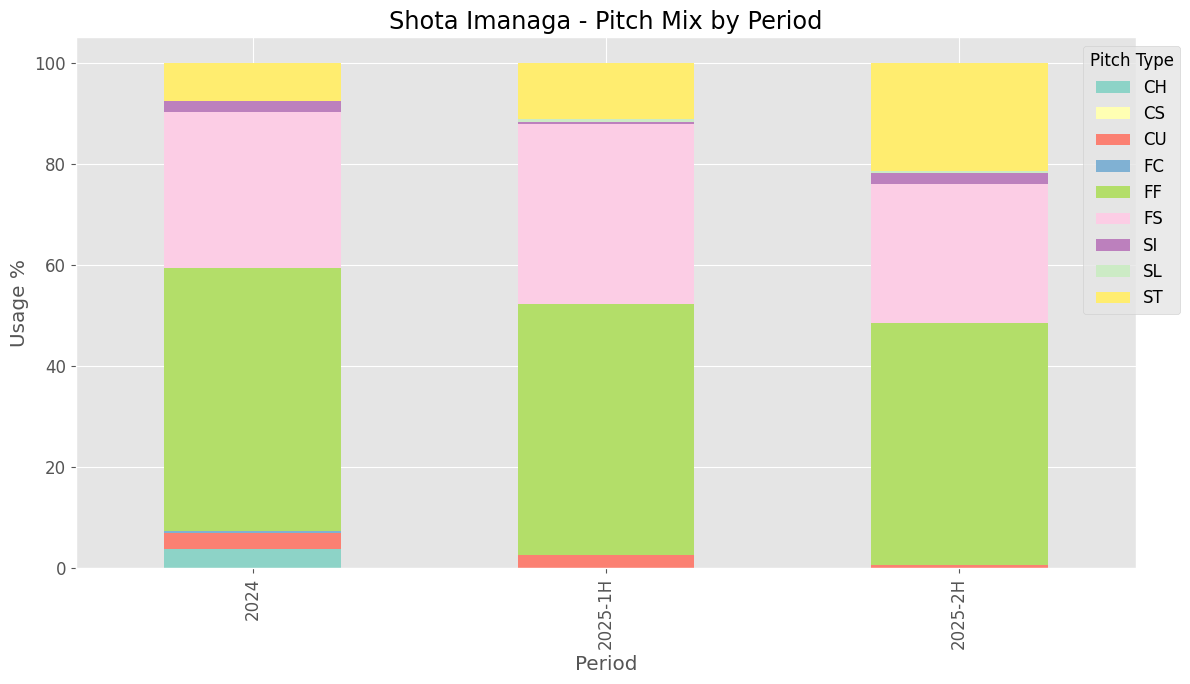


=== Pitch Mix (% usage) ===
pitch_type   CH   CS   CU   FC    FF    FS   SI   SL    ST
period                                                    
2024        3.8  0.0  3.2  0.5  51.9  30.8  2.2  0.0   7.6
2025-1H     0.0  0.0  2.7  0.0  49.5  35.6  0.4  0.6  11.1
2025-2H     0.0  0.0  0.6  0.0  47.9  27.6  2.1  0.3  21.5

=== Biggest Changes (2024 → 2025-2H) ===
  FF: 51.9% → 47.9% (↓4.0%)
  CH: 3.8% → 0.0% (↓3.8%)
  FS: 30.8% → 27.6% (↓3.2%)
  CU: 3.2% → 0.6% (↓2.6%)
  ST: 7.6% → 21.5% (↑13.9%)


In [20]:
mix_pivot = arsenal.pivot_table(index='period', columns='pitch_type', values='pct', fill_value=0)
mix_pivot = mix_pivot.reindex(PERIODS)

mix_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set3')
plt.title('Shota Imanaga - Pitch Mix by Period')
plt.xlabel('Period')
plt.ylabel('Usage %')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Pitch Mix (% usage) ===')
print(mix_pivot.round(1).to_string())

# 2024 vs 2025-2H changes
if '2024' in mix_pivot.index and '2025-2H' in mix_pivot.index:
    first = mix_pivot.loc['2024']
    last = mix_pivot.loc['2025-2H']
    diff = (last - first).sort_values()
    print(f'\n=== Biggest Changes (2024 → 2025-2H) ===')
    for pitch, change in diff.items():
        if abs(change) >= 1.0:
            direction = '↑' if change > 0 else '↓'
            print(f'  {pitch}: {first[pitch]:.1f}% → {last[pitch]:.1f}% ({direction}{abs(change):.1f}%)')

## 5. Velocity Trends by Period

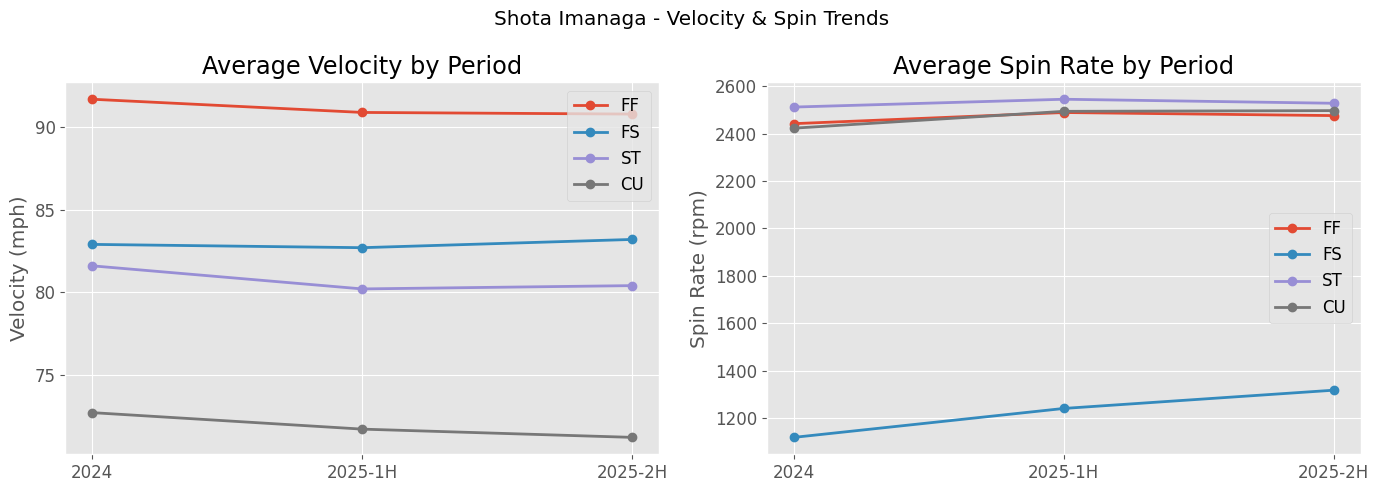


=== Velocity & Spin by Period (Top Pitches) ===

FF:
 period  avg_velo  avg_spin  count
   2024      91.7    2442.0   1343
2025-1H      90.9    2489.0    507
2025-2H      90.8    2476.0    552

FS:
 period  avg_velo  avg_spin  count
   2024      82.9    1119.0    797
2025-1H      82.7    1241.0    365
2025-2H      83.2    1318.0    318

ST:
 period  avg_velo  avg_spin  count
   2024      81.6    2512.0    196
2025-1H      80.2    2545.0    114
2025-2H      80.4    2528.0    248

CU:
 period  avg_velo  avg_spin  count
   2024      72.7    2423.0     84
2025-1H      71.7    2494.0     28
2025-2H      71.2    2497.0      7


In [21]:
velo_by_period = con.execute("""
    SELECT
        period,
        pitch_type,
        ROUND(AVG(release_speed), 1) as avg_velo,
        ROUND(AVG(release_spin_rate), 0) as avg_spin,
        COUNT(*) as count
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY period
""").df()

top_pitches = con.execute("""
    SELECT pitch_type FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY pitch_type
    ORDER BY COUNT(*) DESC
    LIMIT 4
""").df()['pitch_type'].tolist()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

period_order = {p: i for i, p in enumerate(PERIODS)}
for pitch in top_pitches:
    data = velo_by_period[velo_by_period['pitch_type'] == pitch].copy()
    data['period_idx'] = data['period'].map(period_order)
    data = data.sort_values('period_idx')
    axes[0].plot(data['period'], data['avg_velo'], marker='o', label=pitch, linewidth=2)
    axes[1].plot(data['period'], data['avg_spin'], marker='o', label=pitch, linewidth=2)

axes[0].set_title('Average Velocity by Period')
axes[0].set_ylabel('Velocity (mph)')
axes[0].legend()

axes[1].set_title('Average Spin Rate by Period')
axes[1].set_ylabel('Spin Rate (rpm)')
axes[1].legend()

plt.suptitle('Shota Imanaga - Velocity & Spin Trends')
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Velocity & Spin by Period (Top Pitches) ===')
for pitch in top_pitches:
    data = velo_by_period[velo_by_period['pitch_type'] == pitch]
    print(f'\n{pitch}:')
    print(data[['period', 'avg_velo', 'avg_spin', 'count']].to_string(index=False))

## 6. Monthly Velocity Trend (2025 Focus)

2025年の月別球速推移で、前半→後半の変化を細かく見る

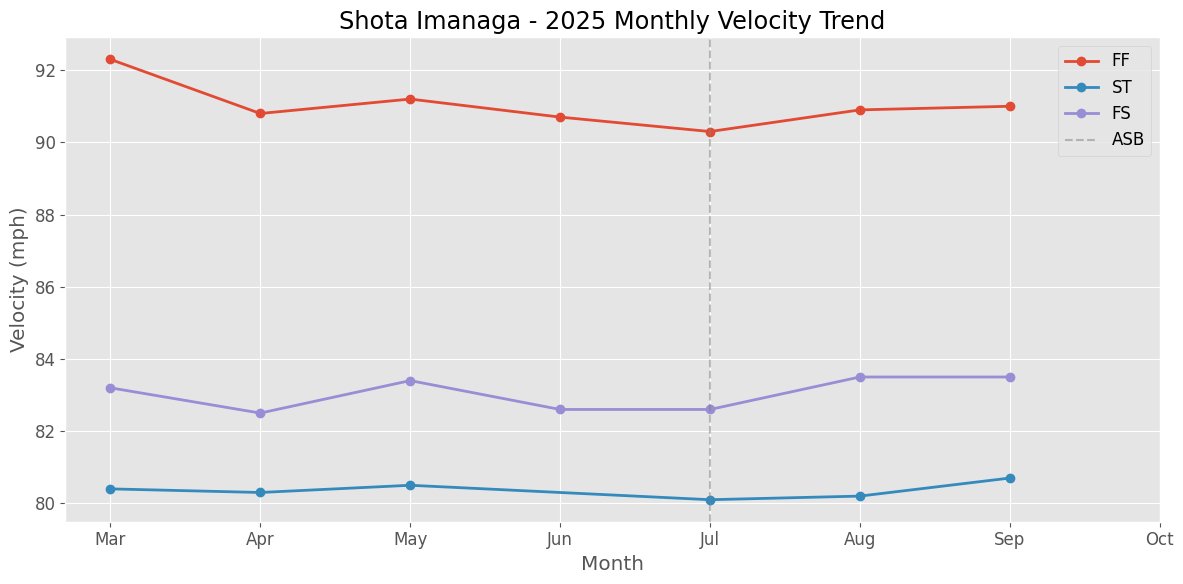

=== 2025 Monthly Velocity ===

FF:
 month  avg_velo  pitches
     3      92.3       79
     4      90.8      223
     5      91.2       38
     6      90.7       48
     7      90.3      255
     8      90.9      243
     9      91.0      173

ST:
 month  avg_velo  pitches
     3      80.4       15
     4      80.3       50
     5      80.5       13
     7      80.1       74
     8      80.2      102
     9      80.7      102

FS:
 month  avg_velo  pitches
     3      83.2       58
     4      82.5      156
     5      83.4       33
     6      82.6       23
     7      82.6      174
     8      83.5      108
     9      83.5      131

=== 2024 Monthly Velocity ===

FS:
 month  avg_velo  pitches
     4      83.2      112
     5      83.1      169
     6      83.1      133
     7      83.0       91
     8      82.6      172
     9      82.4      120

ST:
 month  avg_velo  pitches
     4      82.3       32
     5      81.7       22
     6      81.8       36
     7      81.8       25
    

In [22]:
monthly_velo = con.execute("""
    SELECT
        season,
        EXTRACT(MONTH FROM game_date::DATE) as month,
        pitch_type,
        ROUND(AVG(release_speed), 1) as avg_velo,
        COUNT(*) as pitches
    FROM df
    WHERE pitch_type IN (SELECT pitch_type FROM df GROUP BY pitch_type ORDER BY COUNT(*) DESC LIMIT 3)
    GROUP BY season, month, pitch_type
    HAVING COUNT(*) >= 10
    ORDER BY season, month
""").df()

# Plot 2025 monthly trend
fig, ax = plt.subplots(figsize=(12, 6))
df_2025_monthly = monthly_velo[monthly_velo['season'] == 2025]
for pitch in df_2025_monthly['pitch_type'].unique():
    data = df_2025_monthly[df_2025_monthly['pitch_type'] == pitch]
    ax.plot(data['month'], data['avg_velo'], marker='o', label=pitch, linewidth=2)

ax.axvline(x=7, color='gray', linestyle='--', alpha=0.5, label='ASB')
ax.set_xlabel('Month')
ax.set_ylabel('Velocity (mph)')
ax.set_title('Shota Imanaga - 2025 Monthly Velocity Trend')
ax.set_xticks(range(3, 11))
ax.set_xticklabels(['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
ax.legend()
plt.tight_layout()
plt.show()

# === Text Summary ===
print('=== 2025 Monthly Velocity ===')
for pitch in df_2025_monthly['pitch_type'].unique():
    data = df_2025_monthly[df_2025_monthly['pitch_type'] == pitch]
    print(f'\n{pitch}:')
    print(data[['month', 'avg_velo', 'pitches']].to_string(index=False))

# Also show 2024 for comparison
print('\n=== 2024 Monthly Velocity ===')
df_2024_monthly = monthly_velo[monthly_velo['season'] == 2024]
for pitch in df_2024_monthly['pitch_type'].unique():
    data = df_2024_monthly[df_2024_monthly['pitch_type'] == pitch]
    print(f'\n{pitch}:')
    print(data[['month', 'avg_velo', 'pitches']].to_string(index=False))

## 7. Fatigue Pattern: Inning-by-Inning Velocity

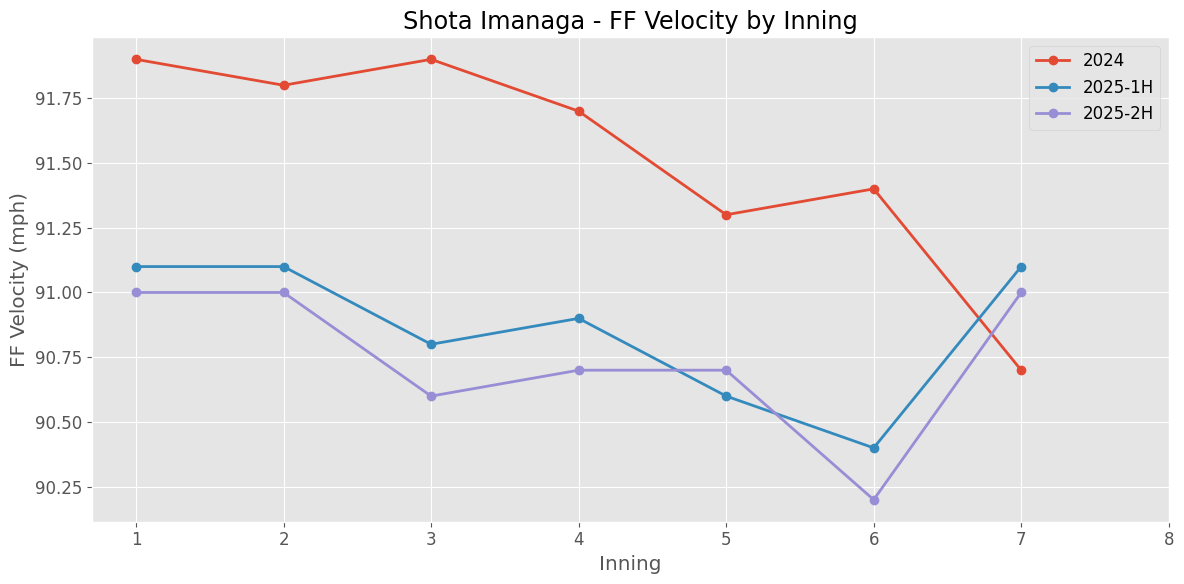


=== FF Velocity by Inning ===
period  2024  2025-1H  2025-2H
inning                        
1       91.9     91.1     91.0
2       91.8     91.1     91.0
3       91.9     90.8     90.6
4       91.7     90.9     90.7
5       91.3     90.6     90.7
6       91.4     90.4     90.2
7       90.7     91.1     91.0

=== Velocity Drop (1st inning → last inning) ===
  2024: 91.9 → 90.7 (inn 7) = -1.2 mph
  2025-1H: 91.1 → 91.1 (inn 7) = +0.0 mph
  2025-2H: 91.0 → 91.0 (inn 7) = +0.0 mph


In [23]:
ff_type = 'FF' if 'FF' in top_pitches else top_pitches[0]

fatigue = con.execute(f"""
    SELECT
        period,
        inning,
        ROUND(AVG(release_speed), 1) as avg_velo,
        COUNT(*) as pitches
    FROM df
    WHERE pitch_type = '{ff_type}' AND inning <= 8
    GROUP BY period, inning
    HAVING COUNT(*) >= 5
    ORDER BY period, inning
""").df()

fig, ax = plt.subplots(figsize=(12, 6))
for period in PERIODS:
    data = fatigue[fatigue['period'] == period]
    if len(data) > 0:
        ax.plot(data['inning'], data['avg_velo'], marker='o', label=period, linewidth=2)

ax.set_xlabel('Inning')
ax.set_ylabel(f'{ff_type} Velocity (mph)')
ax.set_title(f'Shota Imanaga - {ff_type} Velocity by Inning')
ax.set_xticks(range(1, 9))
ax.legend()
plt.tight_layout()
plt.show()

# === Text Summary ===
print(f'\n=== {ff_type} Velocity by Inning ===')
fatigue_pivot = fatigue.pivot_table(index='inning', columns='period', values='avg_velo')
if len(fatigue_pivot.columns) > 0:
    fatigue_pivot = fatigue_pivot.reindex(columns=PERIODS)
print(fatigue_pivot.to_string())

print(f'\n=== Velocity Drop (1st inning → last inning) ===')
for period in PERIODS:
    data = fatigue[fatigue['period'] == period]
    if len(data) >= 2:
        first_velo = data.iloc[0]['avg_velo']
        last_velo = data.iloc[-1]['avg_velo']
        last_inn = int(data.iloc[-1]['inning'])
        drop = last_velo - first_velo
        print(f'  {period}: {first_velo} → {last_velo} (inn {last_inn}) = {drop:+.1f} mph')

## 8. Whiff Rate (空振り率)

空振り率 = 空振り数 / スイング総数

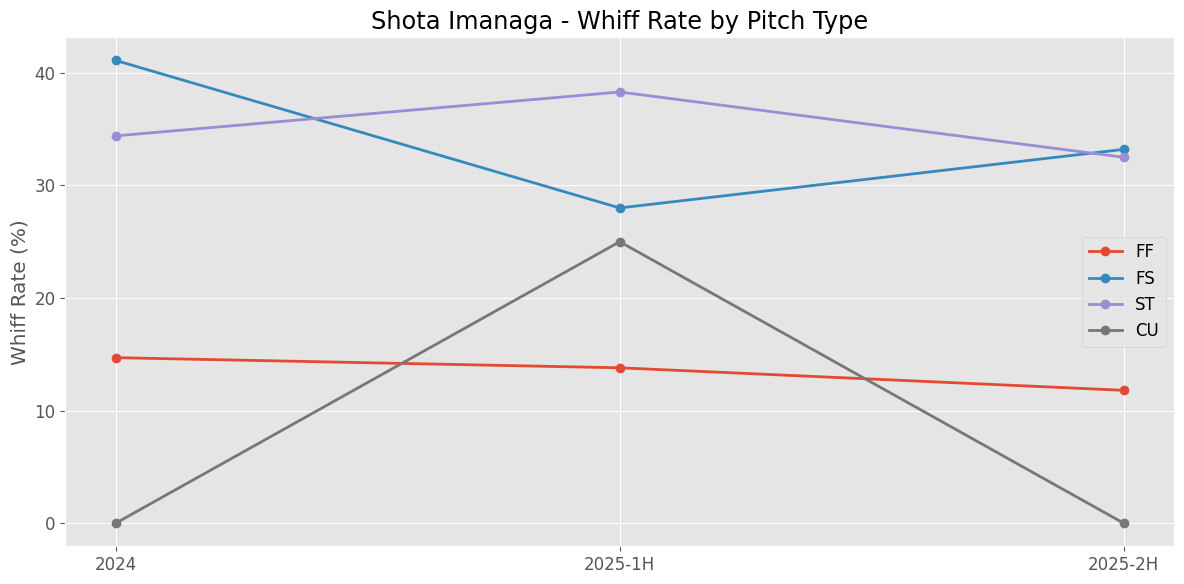


=== Whiff Rate by Pitch Type ===
period      2024  2025-1H  2025-2H
pitch_type                        
CH          32.7      NaN      NaN
CS           0.0      NaN      NaN
CU           0.0     25.0      0.0
FC          14.3      NaN      NaN
FF          14.7     13.8     11.8
FS          41.1     28.0     33.2
SI          33.3      0.0     15.4
SL           NaN     50.0      0.0
ST          34.4     38.3     32.5


In [24]:
whiff = con.execute("""
    SELECT
        period,
        pitch_type,
        COUNT(*) as total_pitches,
        SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) as whiffs,
        SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END) as total_swings,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY period, total_pitches DESC
""").df()

fig, ax = plt.subplots(figsize=(12, 6))
period_order = {p: i for i, p in enumerate(PERIODS)}
for pitch in top_pitches:
    data = whiff[whiff['pitch_type'] == pitch].copy()
    data['period_idx'] = data['period'].map(period_order)
    data = data.sort_values('period_idx')
    if len(data) > 0:
        ax.plot(data['period'], data['whiff_rate'], marker='o', label=pitch, linewidth=2)

ax.set_ylabel('Whiff Rate (%)')
ax.set_title('Shota Imanaga - Whiff Rate by Pitch Type')
ax.legend()
plt.tight_layout()
plt.show()

# === Text Summary ===
print('\n=== Whiff Rate by Pitch Type ===')
whiff_pivot = whiff.pivot_table(index='pitch_type', columns='period', values='whiff_rate')
if len(whiff_pivot.columns) > 0:
    whiff_pivot = whiff_pivot.reindex(columns=PERIODS)
print(whiff_pivot.round(1).to_string())

## 9. Two-Strike Strategy

2ストライクからの「決め球」がどう変わったか

In [25]:
two_strike = con.execute("""
    SELECT
        period,
        pitch_type,
        COUNT(*) as pitches,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period), 1) as pct,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE strikes = 2 AND pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    ORDER BY period, pitches DESC
""").df()

print('=== Two-Strike Pitch Selection ===')
for period in PERIODS:
    data = two_strike[two_strike['period'] == period].head(5)
    print(f'\n--- {period} ---')
    print(data[['pitch_type', 'pitches', 'pct', 'whiff_rate']].to_string(index=False))

=== Two-Strike Pitch Selection ===

--- 2024 ---
pitch_type  pitches  pct  whiff_rate
        FF      369 45.9        17.3
        FS      312 38.8        34.3
        ST       67  8.3        29.7
        CH       43  5.3        21.7
        SI        9  1.1        50.0

--- 2025-1H ---
pitch_type  pitches  pct  whiff_rate
        FS      140 45.5        21.9
        FF      131 42.5         7.1
        ST       34 11.0        45.0
        CU        2  0.6         0.0
        SI        1  0.3         0.0

--- 2025-2H ---
pitch_type  pitches  pct  whiff_rate
        FF      153 42.0        12.4
        FS      134 36.8        25.3
        ST       76 20.9        25.0
        SL        1  0.3         NaN


## 10. Count Situation Analysis

In [26]:
count_analysis = con.execute("""
    SELECT
        period,
        CASE
            WHEN balls = 3 AND strikes = 2 THEN 'Full Count'
            WHEN balls > strikes THEN 'Behind'
            WHEN strikes > balls THEN 'Ahead'
            ELSE 'Even'
        END as count_situation,
        pitch_type,
        COUNT(*) as pitches,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(
            PARTITION BY period,
            CASE
                WHEN balls = 3 AND strikes = 2 THEN 'Full Count'
                WHEN balls > strikes THEN 'Behind'
                WHEN strikes > balls THEN 'Ahead'
                ELSE 'Even'
            END
        ), 1) as pct
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, count_situation, pitch_type
    ORDER BY period, count_situation, pitches DESC
""").df()

print('=== Pitch Selection by Count Situation ===')
for period in PERIODS:
    print(f'\n=== {period} ===')
    for situation in ['Ahead', 'Even', 'Behind', 'Full Count']:
        data = count_analysis[
            (count_analysis['period'] == period) &
            (count_analysis['count_situation'] == situation)
        ].head(3)
        if len(data) > 0:
            top_str = ', '.join([f"{r['pitch_type']} {r['pct']}%" for _, r in data.iterrows()])
            print(f'  {situation}: {top_str}')

=== Pitch Selection by Count Situation ===

=== 2024 ===
  Ahead: FF 43.6%, FS 39.3%, ST 10.2%
  Even: FF 51.4%, FS 27.3%, ST 7.7%
  Behind: FF 66.8%, FS 23.8%, ST 3.4%
  Full Count: FF 60.8%, FS 28.3%, SI 5.0%

=== 2025-1H ===
  Ahead: FS 44.1%, FF 39.4%, ST 14.1%
  Even: FF 47.9%, FS 33.3%, ST 12.7%
  Behind: FF 63.7%, FS 30.2%, ST 5.2%
  Full Count: FF 63.5%, FS 30.8%, ST 3.8%

=== 2025-2H ===
  Ahead: FF 42.9%, FS 30.6%, ST 24.1%
  Even: FF 45.9%, FS 27.6%, ST 22.9%
  Behind: FF 63.2%, FS 21.6%, ST 12.3%
  Full Count: FF 44.7%, FS 29.8%, ST 25.5%


## 11. Batted Ball Results (被打球)

打たれた時の結果を期間別に比較

In [27]:
batted = con.execute("""
    SELECT
        period,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(AVG(launch_angle), 1) as avg_launch_angle,
        ROUND(100.0 * SUM(CASE WHEN launch_speed >= 95 THEN 1 ELSE 0 END) / COUNT(*), 1) as hard_hit_pct,
        ROUND(AVG(estimated_ba_using_speedangle), 3) as avg_xBA,
        ROUND(AVG(estimated_woba_using_speedangle), 3) as avg_xwOBA
    FROM df
    WHERE launch_speed IS NOT NULL
    GROUP BY period
    ORDER BY period
""").df()

print('=== Batted Ball Results by Period ===')
print(batted.to_string(index=False))

# By pitch type
batted_by_pitch = con.execute("""
    SELECT
        period,
        pitch_type,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(AVG(estimated_ba_using_speedangle), 3) as avg_xBA
    FROM df
    WHERE launch_speed IS NOT NULL AND pitch_type IS NOT NULL
    GROUP BY period, pitch_type
    HAVING COUNT(*) >= 10
    ORDER BY period, batted_balls DESC
""").df()

print('\n=== Batted Ball by Pitch Type (min 10 BIP) ===')
for period in PERIODS:
    data = batted_by_pitch[batted_by_pitch['period'] == period]
    print(f'\n--- {period} ---')
    print(data[['pitch_type', 'batted_balls', 'avg_exit_velo', 'avg_xBA']].to_string(index=False))

=== Batted Ball Results by Period ===
 period  batted_balls  avg_exit_velo  avg_launch_angle  hard_hit_pct  avg_xBA  avg_xwOBA
   2024           992           81.7              23.8          22.7    0.312      0.366
2025-1H           388           83.3              27.0          25.0    0.271      0.339
2025-2H           437           82.6              25.6          28.8    0.317      0.408

=== Batted Ball by Pitch Type (min 10 BIP) ===

--- 2024 ---
pitch_type  batted_balls  avg_exit_velo  avg_xBA
        FF           584           83.4    0.292
        FS           275           79.1    0.328
        ST            58           77.2    0.369
        CH            35           78.2    0.304
        SI            20           82.1    0.221
        CU            14           82.4    0.607

--- 2025-1H ---
pitch_type  batted_balls  avg_exit_velo  avg_xBA
        FF           216           84.2    0.274
        FS           136           81.5    0.278
        ST            27           82

## 12. Time Through Order (打順周り別)

1巡目/2巡目/3巡目で打たれ方がどう変わるか → 球種バレの手がかり

In [28]:
# Time Through Order analysis
# at_bat_number resets per game, we approximate TTO by grouping at_bat_number
tto = con.execute("""
    WITH batter_pa AS (
        SELECT
            period,
            game_pk,
            batter,
            at_bat_number,
            DENSE_RANK() OVER(PARTITION BY game_pk, batter ORDER BY at_bat_number) as pa_num
        FROM df
        GROUP BY period, game_pk, batter, at_bat_number
    ),
    tto_tagged AS (
        SELECT
            d.*,
            CASE
                WHEN b.pa_num = 1 THEN '1st'
                WHEN b.pa_num = 2 THEN '2nd'
                ELSE '3rd+'
            END as tto
        FROM df d
        JOIN batter_pa b ON d.game_pk = b.game_pk AND d.batter = b.batter AND d.at_bat_number = b.at_bat_number
    )
    SELECT
        period,
        tto,
        COUNT(*) as pitches,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM tto_tagged
    GROUP BY period, tto
    ORDER BY period, tto
""").df()

print('=== Whiff Rate by Time Through Order ===')
tto_pivot = tto.pivot_table(index='tto', columns='period', values='whiff_rate')
tto_pivot = tto_pivot.reindex(columns=PERIODS)
print(tto_pivot.round(1).to_string())

# Batted ball quality by TTO
tto_batted = con.execute("""
    WITH batter_pa AS (
        SELECT
            period,
            game_pk,
            batter,
            at_bat_number,
            DENSE_RANK() OVER(PARTITION BY game_pk, batter ORDER BY at_bat_number) as pa_num
        FROM df
        GROUP BY period, game_pk, batter, at_bat_number
    ),
    tto_tagged AS (
        SELECT
            d.*,
            CASE
                WHEN b.pa_num = 1 THEN '1st'
                WHEN b.pa_num = 2 THEN '2nd'
                ELSE '3rd+'
            END as tto
        FROM df d
        JOIN batter_pa b ON d.game_pk = b.game_pk AND d.batter = b.batter AND d.at_bat_number = b.at_bat_number
    )
    SELECT
        period,
        tto,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(AVG(estimated_woba_using_speedangle), 3) as avg_xwOBA
    FROM tto_tagged
    WHERE launch_speed IS NOT NULL
    GROUP BY period, tto
    ORDER BY period, tto
""").df()

print('\n=== Batted Ball by Time Through Order ===')
for period in PERIODS:
    data = tto_batted[tto_batted['period'] == period]
    print(f'\n--- {period} ---')
    print(data[['tto', 'batted_balls', 'avg_exit_velo', 'avg_xwOBA']].to_string(index=False))

=== Whiff Rate by Time Through Order ===
period  2024  2025-1H  2025-2H
tto                           
1st     26.6     20.3     25.0
2nd     26.4     22.0     22.9
3rd+    25.0     24.7     17.8

=== Batted Ball by Time Through Order ===

--- 2024 ---
 tto  batted_balls  avg_exit_velo  avg_xwOBA
 1st           382           82.0      0.357
 2nd           350           81.6      0.347
3rd+           260           81.2      0.404

--- 2025-1H ---
 tto  batted_balls  avg_exit_velo  avg_xwOBA
 1st           170           83.1      0.331
 2nd           147           82.9      0.320
3rd+            71           84.2      0.395

--- 2025-2H ---
 tto  batted_balls  avg_exit_velo  avg_xwOBA
 1st           178           80.7      0.505
 2nd           158           83.8      0.378
3rd+           101           84.1      0.316


## 13. Left/Right Batter Splits (左右別)

ST(スウィーパー)の効きが左右で違うか確認

In [29]:
# L/R splits - pitch usage and effectiveness
lr_arsenal = con.execute("""
    SELECT
        period,
        stand,
        pitch_type,
        COUNT(*) as count,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period, stand), 1) as pct,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate
    FROM df
    WHERE pitch_type IS NOT NULL
    GROUP BY period, stand, pitch_type
    HAVING COUNT(*) >= 10
    ORDER BY period, stand, count DESC
""").df()

print('=== Pitch Usage & Whiff Rate by Batter Side ===')
for period in PERIODS:
    print(f'\n=== {period} ===')
    for side in ['L', 'R']:
        data = lr_arsenal[(lr_arsenal['period'] == period) & (lr_arsenal['stand'] == side)]
        print(f'\n  vs {side}HB:')
        print(data[['pitch_type', 'count', 'pct', 'whiff_rate']].to_string(index=False))

# Batted ball by side
lr_batted = con.execute("""
    SELECT
        period,
        stand,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(AVG(estimated_woba_using_speedangle), 3) as avg_xwOBA,
        ROUND(100.0 * SUM(CASE WHEN launch_speed >= 95 THEN 1 ELSE 0 END) / COUNT(*), 1) as hard_hit_pct
    FROM df
    WHERE launch_speed IS NOT NULL
    GROUP BY period, stand
    ORDER BY period, stand
""").df()

print('\n=== Batted Ball by Batter Side ===')
print(lr_batted.to_string(index=False))

# ST-specific L/R splits
lr_st = con.execute("""
    SELECT
        period,
        stand,
        COUNT(*) as pitches,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate,
        ROUND(AVG(CASE WHEN launch_speed IS NOT NULL THEN estimated_ba_using_speedangle END), 3) as xBA_on_contact
    FROM df
    WHERE pitch_type = 'ST'
    GROUP BY period, stand
    ORDER BY period, stand
""").df()

print('\n=== ST (Sweeper) Left/Right Splits ===')
print(lr_st.to_string(index=False))

=== Pitch Usage & Whiff Rate by Batter Side ===

=== 2024 ===

  vs LHB:
pitch_type  count  pct  whiff_rate
        FF    259 49.6        12.9
        ST    173 33.1        36.0
        FS     67 12.8        38.6
        SI     23  4.4        64.3

  vs RHB:
pitch_type  count  pct  whiff_rate
        FF   1084 52.5        15.1
        FS    730 35.4        41.3
        CH     99  4.8        32.7
        CU     80  3.9         0.0
        SI     35  1.7         6.3
        ST     23  1.1        20.0
        FC     12  0.6        14.3

=== 2025-1H ===

  vs LHB:
pitch_type  count  pct  whiff_rate
        FF    127 53.8         9.5
        ST     86 36.4        42.4
        FS     23  9.7        28.6

  vs RHB:
pitch_type  count  pct  whiff_rate
        FF    380 49.0        15.0
        FS    342 44.1        27.9
        ST     28  3.6        28.6
        CU     26  3.4        25.0

=== 2025-2H ===

  vs LHB:
pitch_type  count  pct  whiff_rate
        FF    141 49.0        11.3
        S

## 14. Monthly Batted Ball Metrics (月別被打球)

1H/2Hの2分割より細かく、いつから悪化し始めたか確認

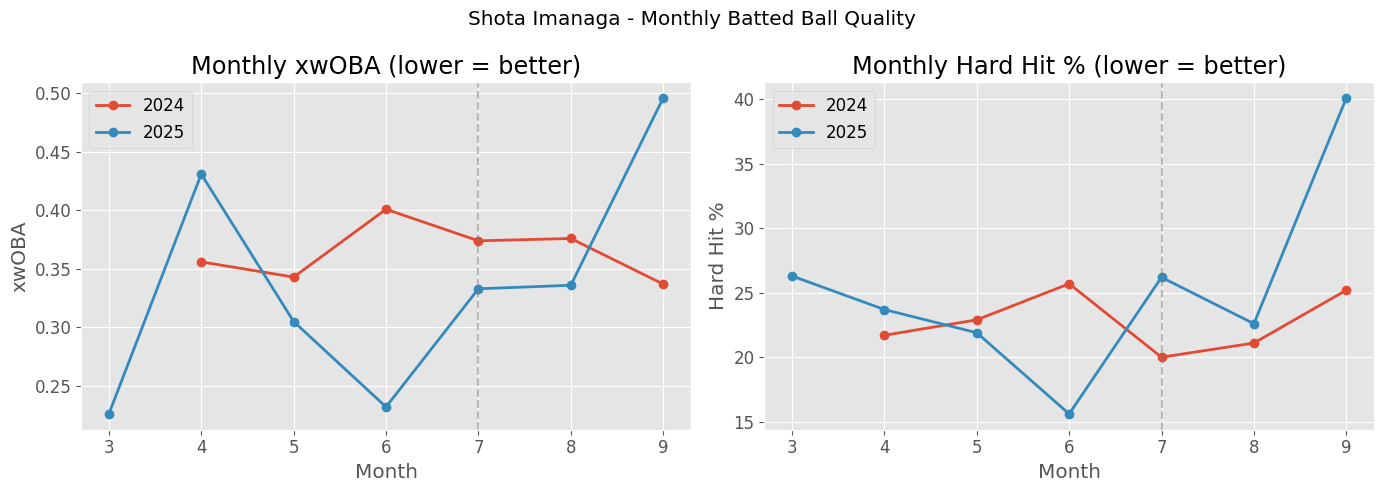

=== Monthly Batted Ball Metrics ===

--- 2024 ---
 month  batted_balls  avg_exit_velo  hard_hit_pct  avg_xwOBA
     4           157           82.3          21.7      0.356
     5           170           81.2          22.9      0.343
     6           167           82.5          25.7      0.401
     7           150           80.5          20.0      0.374
     8           213           81.1          21.1      0.376
     9           135           82.7          25.2      0.337

--- 2025 ---
 month  batted_balls  avg_exit_velo  hard_hit_pct  avg_xwOBA
     3            57           84.0          26.3      0.226
     4           169           82.9          23.7      0.431
     5            32           82.9          21.9      0.305
     6            32           80.8          15.6      0.232
     7           210           82.0          26.2      0.333
     8           168           82.0          22.6      0.336
     9           157           85.3          40.1      0.496


In [30]:
# Monthly batted ball metrics
monthly_batted = con.execute("""
    SELECT
        season,
        EXTRACT(MONTH FROM game_date::DATE) as month,
        COUNT(*) as batted_balls,
        ROUND(AVG(launch_speed), 1) as avg_exit_velo,
        ROUND(100.0 * SUM(CASE WHEN launch_speed >= 95 THEN 1 ELSE 0 END) / COUNT(*), 1) as hard_hit_pct,
        ROUND(AVG(estimated_woba_using_speedangle), 3) as avg_xwOBA
    FROM df
    WHERE launch_speed IS NOT NULL
    GROUP BY season, month
    HAVING COUNT(*) >= 20
    ORDER BY season, month
""").df()

# Plot xwOBA monthly
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for year in YEARS:
    data = monthly_batted[monthly_batted['season'] == year]
    axes[0].plot(data['month'], data['avg_xwOBA'], marker='o', label=str(year), linewidth=2)
    axes[1].plot(data['month'], data['hard_hit_pct'], marker='o', label=str(year), linewidth=2)

axes[0].axvline(x=7, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('xwOBA')
axes[0].set_title('Monthly xwOBA (lower = better)')
axes[0].legend()

axes[1].axvline(x=7, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Hard Hit %')
axes[1].set_title('Monthly Hard Hit % (lower = better)')
axes[1].legend()

plt.suptitle('Shota Imanaga - Monthly Batted Ball Quality')
plt.tight_layout()
plt.show()

# === Text Summary ===
print('=== Monthly Batted Ball Metrics ===')
for year in YEARS:
    data = monthly_batted[monthly_batted['season'] == year]
    print(f'\n--- {year} ---')
    print(data[['month', 'batted_balls', 'avg_exit_velo', 'hard_hit_pct', 'avg_xwOBA']].to_string(index=False))

## 15. FS (Split-finger) Zone Analysis

スプリットがどこに投げられているか → ゾーン内に甘く入っているのか、ボールゾーンで見逃されているのか

=== FS Zone Analysis ===

--- 2024 ---
zone_type  pitches  pct  swing_rate  whiff_rate
    Chase      476 59.7        47.1        55.8
  In Zone      321 40.3        87.2        29.3

--- 2025-1H ---
zone_type  pitches  pct  swing_rate  whiff_rate
    Chase      190 52.1        40.0        38.2
  In Zone      175 47.9        81.1        22.5

--- 2025-2H ---
zone_type  pitches  pct  swing_rate  whiff_rate
    Chase      170 53.5        43.5        40.5
  In Zone      148 46.5        86.5        28.9


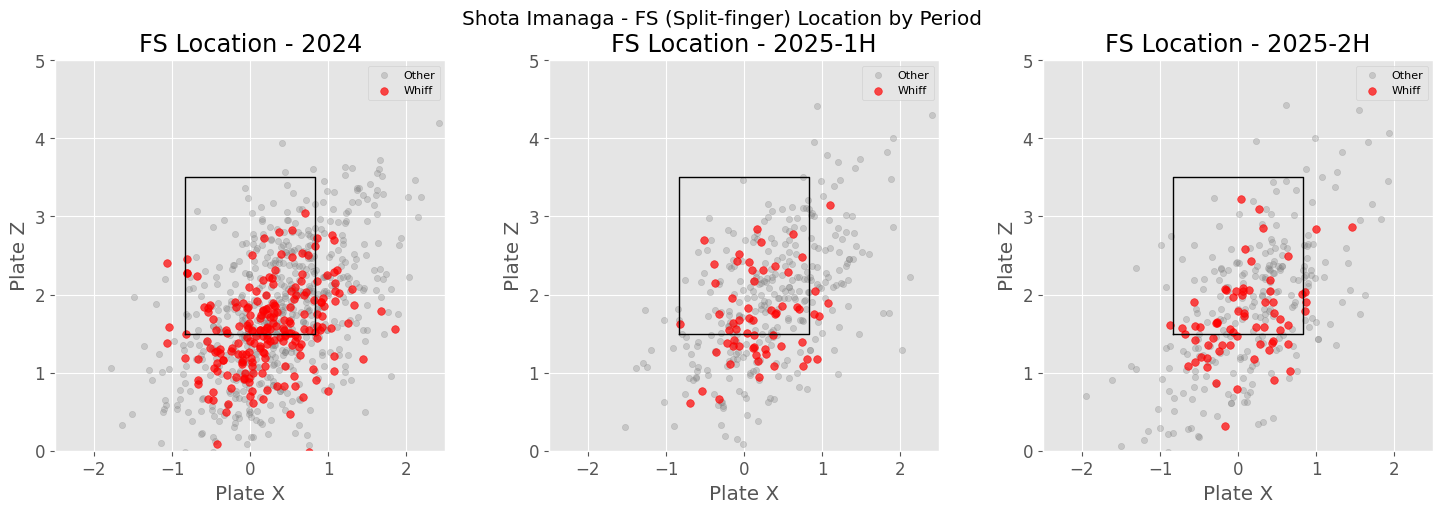


=== FS Average Location & Movement ===
 period  avg_plate_x  avg_plate_z  avg_h_break  avg_v_break  pitches
   2024         0.31         1.68          0.9          0.6      797
2025-1H         0.32         1.90          1.1          0.6      365
2025-2H         0.14         1.80          1.1          0.5      318


In [31]:
# FS zone analysis
# zone 1-9 = strike zone, 11-14 = chase/waste zones
fs_zone = con.execute("""
    SELECT
        period,
        CASE
            WHEN zone BETWEEN 1 AND 9 THEN 'In Zone'
            WHEN zone BETWEEN 11 AND 14 THEN 'Chase'
            ELSE 'Waste'
        END as zone_type,
        COUNT(*) as pitches,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(PARTITION BY period), 1) as pct,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked'
        ) THEN 1 ELSE 0 END) /
        NULLIF(SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END), 0), 1) as whiff_rate,
        ROUND(100.0 * SUM(CASE WHEN description IN (
            'swinging_strike', 'swinging_strike_blocked',
            'foul', 'foul_tip', 'foul_bunt',
            'hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'
        ) THEN 1 ELSE 0 END) / COUNT(*), 1) as swing_rate
    FROM df
    WHERE pitch_type = 'FS' AND zone IS NOT NULL
    GROUP BY period, zone_type
    ORDER BY period, zone_type
""").df()

print('=== FS Zone Analysis ===')
for period in PERIODS:
    data = fs_zone[fs_zone['period'] == period]
    print(f'\n--- {period} ---')
    print(data[['zone_type', 'pitches', 'pct', 'swing_rate', 'whiff_rate']].to_string(index=False))

# FS location scatter by period
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, period in enumerate(PERIODS):
    fs_data = con.execute(f"""
        SELECT plate_x, plate_z, description
        FROM df
        WHERE pitch_type = 'FS' AND period = '{period}'
          AND plate_x IS NOT NULL AND plate_z IS NOT NULL
    """).df()

    whiff_mask = fs_data['description'].isin(['swinging_strike', 'swinging_strike_blocked'])

    axes[i].scatter(fs_data[~whiff_mask]['plate_x'], fs_data[~whiff_mask]['plate_z'],
                    alpha=0.3, s=20, c='gray', label='Other')
    axes[i].scatter(fs_data[whiff_mask]['plate_x'], fs_data[whiff_mask]['plate_z'],
                    alpha=0.7, s=30, c='red', label='Whiff')

    # Strike zone box (approximate)
    axes[i].plot([-0.83, 0.83, 0.83, -0.83, -0.83],
                 [1.5, 1.5, 3.5, 3.5, 1.5], 'k-', linewidth=1)
    axes[i].set_xlim(-2.5, 2.5)
    axes[i].set_ylim(0, 5)
    axes[i].set_title(f'FS Location - {period}')
    axes[i].set_xlabel('Plate X')
    axes[i].set_ylabel('Plate Z')
    axes[i].legend(fontsize=8)
    axes[i].set_aspect('equal')

plt.suptitle('Shota Imanaga - FS (Split-finger) Location by Period')
plt.tight_layout()
plt.show()

# Average FS location
fs_location = con.execute("""
    SELECT
        period,
        ROUND(AVG(plate_x), 2) as avg_plate_x,
        ROUND(AVG(plate_z), 2) as avg_plate_z,
        ROUND(AVG(pfx_x), 1) as avg_h_break,
        ROUND(AVG(pfx_z), 1) as avg_v_break,
        COUNT(*) as pitches
    FROM df
    WHERE pitch_type = 'FS' AND plate_x IS NOT NULL
    GROUP BY period
    ORDER BY period
""").df()

print('\n=== FS Average Location & Movement ===')
print(fs_location.to_string(index=False))

## 16. Summary

In [32]:
print('=' * 60)
print('SHOTA IMANAGA 2024-2025 ANALYSIS SUMMARY')
print('=' * 60)

# Games & Pitches
print('\n[Workload]')
for _, row in summary.iterrows():
    print(f'  {row["period"]}: {int(row["games"])} games, {int(row["pitches"]):,} pitches, avg {row["avg_velo"]} mph')

# Pitch mix changes
print(f'\n[Pitch Mix Changes]')
for period_pair in [('2024', '2025-1H'), ('2025-1H', '2025-2H')]:
    p1, p2 = period_pair
    if p1 in mix_pivot.index and p2 in mix_pivot.index:
        first = mix_pivot.loc[p1]
        last = mix_pivot.loc[p2]
        diff = (last - first).sort_values()
        changes = [(p, c) for p, c in diff.items() if abs(c) >= 2.0]
        if changes:
            print(f'  {p1} → {p2}:')
            for pitch, change in changes:
                direction = '↑' if change > 0 else '↓'
                print(f'    {pitch}: {first[pitch]:.1f}% → {last[pitch]:.1f}% ({direction}{abs(change):.1f}%)')

# Velocity
print(f'\n[Fastball Velocity]')
ff_data = velo_by_period[velo_by_period['pitch_type'] == ff_type]
for _, row in ff_data.iterrows():
    print(f'  {row["period"]}: {row["avg_velo"]} mph ({int(row["count"])} pitches)')

# Best whiff pitch per period
print(f'\n[Best Whiff Rate Pitch]')
for period in PERIODS:
    period_whiff = whiff[(whiff['period'] == period) & (whiff['total_swings'] >= 20)]
    if len(period_whiff) > 0:
        best = period_whiff.loc[period_whiff['whiff_rate'].idxmax()]
        print(f'  {period}: {best["pitch_type"]} ({best["whiff_rate"]}%)')

# Batted ball
print(f'\n[Batted Ball Quality]')
for _, row in batted.iterrows():
    print(f'  {row["period"]}: xwOBA {row["avg_xwOBA"]}, Hard Hit {row["hard_hit_pct"]}%, Exit Velo {row["avg_exit_velo"]} mph')

print('\n' + '=' * 60)

SHOTA IMANAGA 2024-2025 ANALYSIS SUMMARY

[Workload]
  2024: 29 games, 2,594 pitches, avg 87.1 mph
  2025-1H: 12 games, 1,026 pitches, avg 86.2 mph
  2025-2H: 13 games, 1,152 pitches, avg 86.3 mph

[Pitch Mix Changes]
  2024 → 2025-1H:
    CH: 3.8% → 0.0% (↓3.8%)
    FF: 51.9% → 49.5% (↓2.4%)
    ST: 7.6% → 11.1% (↑3.5%)
    FS: 30.8% → 35.6% (↑4.8%)
  2025-1H → 2025-2H:
    FS: 35.6% → 27.6% (↓8.0%)
    CU: 2.7% → 0.6% (↓2.1%)
    ST: 11.1% → 21.5% (↑10.4%)

[Fastball Velocity]
  2024: 91.7 mph (1343 pitches)
  2025-1H: 90.9 mph (507 pitches)
  2025-2H: 90.8 mph (552 pitches)

[Best Whiff Rate Pitch]
  2024: FS (41.1%)
  2025-1H: ST (38.3%)
  2025-2H: FS (33.2%)

[Batted Ball Quality]
  2024: xwOBA 0.366, Hard Hit 22.7%, Exit Velo 81.7 mph
  2025-1H: xwOBA 0.339, Hard Hit 25.0%, Exit Velo 83.3 mph
  2025-2H: xwOBA 0.408, Hard Hit 28.8%, Exit Velo 82.6 mph

